In [ ]:
import xarray as xr; xr.set_options(keep_attrs = True)
import numpy as np
import pandas as pd

import xclim
import glob
import re

from scipy.stats import norm, gamma, gaussian_kde

In [9]:
ds = xr.open_dataset("../99_tamsat/tamsat_1983_rfe-filled_0.25.v3.1.nc").rfe_filled

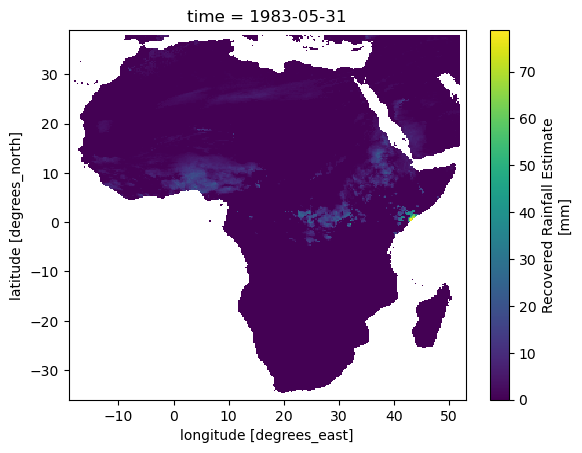

In [12]:
ds.isel(time = 150).plot()

---
### **Extract time series & monthly spatial patterns from raw data**
```
synda install domain=AFR-44,AFR-22 frequency=day variable=pr experiment=rcp85,historical
```

In [3]:
# define study region
sr_lon = [-3,24]
sr_lat = [14,16]

# also larger region for spatial patterns
sp_lon = [-20,40]
sp_lat = [0,30]
obs_dates = ["1980", "2022"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def wrap_lon(ds):
    
    # if dataset longitudes are defined as 0:360, wrap the data from -180:180
    if ds.lon.max() > 350:
        ds["lon"] = (ds.lon.dims, (((ds.lon.values + 180) % 360) - 180), ds.lon.attrs)
        
        # can only reindex if lon is a dimension - if only a coordinate, should already be in correct order
        if "lon" in ds.dims:
            ds = ds.reindex({ "lon" : np.sort(ds.lon) })
    return ds

In [4]:
afr44 = sorted(set([re.sub("historical", "rcp85", fnm) for fnm in glob.glob("../synda/data/cordex/output/AFR-44/*/*/*/*/*/*/day/pr")]))
afr22 = sorted(set([re.sub("historical", "rcp85", fnm) for fnm in glob.glob("../synda/data/cordex/output/AFR-22/*/*/*/*/*/*/day/pr")]))

for fpath in afr44 + afr22:
    
    print(fpath, end = ": ")
    
    # list all files (RCP85 & historical)
    fl = sorted(glob.glob(re.sub("rcp85", "*", fpath)+"/*/*.nc"))
    
    if len(fl) == 0: 
        print("no files")
        continue
        
    n_hist = sum(["historical" in fnm for fnm in fl])
    n_rcp = sum(["rcp85" in fnm for fnm in fl])
    
    if n_hist == 0:
        print("no historical data")
        continue
    if n_rcp == 0: 
        print("no scenario data")
        continue
    
    # construct new filename
    ts_fnm = re.sub("historical", "historical-rcp85", "cordex/"+re.sub("-[0-9]{8}", "-"+fl[-1][-11:-3], fl[0].split("/")[-1]))
    sp_fnm = re.sub("[0-9]{8}-[0-9]{8}", "-".join(obs_dates), re.sub("pr", "pr-spatial", ts_fnm))
    
    if len(glob.glob(sp_fnm)) > 0:
        print("already processed")
        continue
    
    ds = wrap_lon(xr.open_mfdataset(fl))
    xy_dims = ds.cf.axes["X"] + ds.cf.axes["Y"]
    
    # get variable of interest, convert to correct units
    pr = xclim.core.units.convert_units_to(ds.pr, "mm/day")
    
    # record files used (including version number)
    pr = pr.assign_attrs(file_list = ", ".join([re.sub(".+pr/", "", fnm) for fnm in fl]))
    
    # skip if time series already exists
    if len(glob.glob(ts_fnm)) == 0:
        # identify study region, compute time series, save
        study_region = np.logical_and(np.logical_and(ds.lat >= sr_lat[0], ds.lat <= sr_lat[1]), np.logical_and(ds.lon >= sr_lon[0], ds.lon <= sr_lon[1]))
        ts = pr.where(study_region == 1).mean(xy_dims)
        ts.to_netcdf(ts_fnm)
        
    # skip if spatial pattern already exists
    if len(glob.glob(sp_fnm)) == 0:
        # extract region for evaluation of spatial patterns
        spatial_region = np.logical_and(np.logical_and(ds.lat >= sp_lat[0], ds.lat <= sp_lat[1]), np.logical_and(ds.lon >= sp_lon[0], ds.lon <= sp_lon[1]))
        sp = pr.where(spatial_region == 1).sel(time = slice(obs_dates[0], obs_dates[1])).groupby("time.month").mean().dropna(xy_dims[0], "all").dropna(xy_dims[1], "all")
        sp.to_netcdf(sp_fnm)
        
    print("saved")
        

../synda/data/cordex/output/AFR-44/CCCma/CCCma-CanESM2/rcp85/r1i1p1/CanRCM4/r2/day/pr: already processed
../synda/data/cordex/output/AFR-44/CLMcom/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/CCLM4-8-17/v1/day/pr: already processed
../synda/data/cordex/output/AFR-44/CLMcom/ICHEC-EC-EARTH/rcp85/r12i1p1/CCLM4-8-17/v1/day/pr: already processed
../synda/data/cordex/output/AFR-44/CLMcom/MOHC-HadGEM2-ES/rcp85/r1i1p1/CCLM4-8-17/v1/day/pr: already processed
../synda/data/cordex/output/AFR-44/CLMcom/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/CCLM4-8-17/v1/day/pr: already processed
../synda/data/cordex/output/AFR-44/DMI/ICHEC-EC-EARTH/rcp85/r3i1p1/HIRHAM5/v2/day/pr: already processed
../synda/data/cordex/output/AFR-44/GERICS/IPSL-IPSL-CM5A-LR/rcp85/r1i1p1/REMO2009/v1/day/pr: already processed
../synda/data/cordex/output/AFR-44/GERICS/MIROC-MIROC5/rcp85/r1i1p1/REMO2009/v1/day/pr: already processed
../synda/data/cordex/output/AFR-44/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/REMO2009/v1/day/pr: already processed
../synda/data/

---
### **Drought indices**

In [3]:
## DEFINE INDICES

def jun_total(ts):
    
    jt = ts.resample(time = "MS").sum().groupby("time.month")[6]
    jt = convert_calendar(jt, "default", align_on = "date").rename("june_total")
    return jt

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def anom_diff_ts(ts, sm = 15, t_0 = 0):
    
    # t_0 is start of year used for accumulation of anomalies (should be in middle of dry season - default is to start from beginning of calendar year)
    # sm is number of days used to smooth the anomalies (default is 15, ie day +- 7 days)
    
    # wrap year at t_0 by shifting all values forwards
    ts = ts.shift(time = -t_0)
    
    # daily anomaly wrt annual mean
    anom = ts.groupby("time.year") - ts.groupby("time.year").mean("time")
    
    # # only accumulate anomalies after t_0 (per original code)
    # anom = anom.sel(time = [d >= t_0 for d in ts.time.dt.dayofyear.values])

    # cumulative daily anomalies each year
    anom_cum = anom.groupby("time.year").cumsum()
    
    # smooth the cumulative anomalies
    anom_sm = anom_cum.rolling(time = sm, center = True).mean()
    
    # differences of smoothed anomalies
    anom_diff = anom_sm.diff("time")
    
    # push the anomalies back to have the correct dates
    anom_diff = anom_diff.shift(time = t_0)
    
    return anom_diff


def rainy_season(ts, sm = 15, t_0 = 0, longest_run = True):
        
    # get differences of smoothed anomalies
    anom_ts = anom_diff_ts(ts, sm = sm, t_0 = t_0)
    
    if longest_run:
        # only include the single longest wet period
        
        # count number of consecutive days of positive gradient in cumulative precip
        rs_length = xclim.indices.run_length.rle(xr.ones_like(anom_ts).where(anom_ts > 0, 0))
        
        # tag all days with length of period to which they belong
        rs_length = rs_length.ffill("time")
        
        # identify those days that are part of the longest wet period in each year
        rs = rs_length.where(rs_length.groupby("time.year") - rs_length.groupby("time.year").max() == 0)
    
    else:
        # include all days with positive gradient as part of wet season
        rs = anom_ts.where(anom_ts > 0)
        
    # convert calendar to Gregorian, matching dates
    rs = xclim.core.calendar.convert_calendar(rs, "default", align_on = "date")
    
    # get start & end of rainy season
    onsets = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").min().dt.dayofyear.rename("rs_onset")
    ends = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").max().dt.dayofyear.rename("rs_end")
    
    # duration of rainy season
    durations = (ends - onsets).rename("rs_duration")
    
    return onsets, ends, durations

###############################################################################################################
## OTHER METHODS

def qqplot(ts, ax = None, dist = norm, marker = ".", ax_labels = True, **kwargs): 
    
    ts = ts[np.isfinite(ts)] 
    x = np.arange(0,1,1/(len(ts)+1))[1:]
    fitted = dist.fit(ts)
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (5,5), dpi = 100, facecolor = "w")
        
    ax.scatter(dist.ppf(x, *fitted), sorted(ts), marker = marker, **kwargs)
    
    vmin = min([ts.min(), dist.ppf(x, *fitted).min()])
    vmax = max([ts.max(), dist.ppf(x, *fitted).max()])
    ax.plot((vmin, vmax), (vmin, vmax), ls = "--", color = "k")
    
    if ax_labels:
        ax.set_xlabel("Fitted"); ax.set_ylabel("Observed")

        
###############################################################################################################
# SAVE FOR CLIMATE EXPLORER

def cx_csv(da, fnm = None):
    
    # save CSV for easy import into Climate Explorer
    
    rnm = da.run.values[0]
    da = da.squeeze(drop = True)
    fnm_string = da.name+"_"+re.sub(" ", "_", rnm)
    
    if fnm is None:
        fnm = "ts/"+fnm_string
    
    if "time" in da.dims:
        da = da.assign_coords(time = da.time.dt.year).rename(time = "#time")
    elif "year" in da.dims:
        da = da.rename(year = "#time")
    else:
        print(da.dims)
        return

    # write to csv
    fnm = re.sub(".txt", "", fnm)+".txt"
    da.to_dataframe().to_csv(fnm, sep = " ")
    
    # add a text string specifying the units (don't think format is correct here)
    if "units" in da.attrs:
        unit_string = "# "+da.name+" ["+da.units+"]"
        unit_string = "# variable ["+da.units+"]"
        ! echo "$unit_string" >> $fnm
    
    # add a line specifying the model & variable name, to be used as filename when uploading
    fnm_string = "# "+fnm_string
    ! echo "$fnm_string" >> $fnm